# DATA3888 Project Report: Holiday Planner

COVID C4

**Note:**

Our final submission for the report would need to be a ZIP file containing:
- this report;
- our data/ folder, containing all data files needed by this notebook and by our python analysis code files; and
- our python analysis code files (common.py, analytics.py, analytics_clustering.py, analytics_helper.py, analytics_helper_clustering.py); and
- main.py and mapping.py.

In [1]:
import itertools
import more_itertools
import random
import matplotlib.pyplot as plt

from statistics import mean

from analytics_clustering import *
from analytics_helper_clustering import *
from analytics import *
from analytics_helper import *
from common import *

from IPython.display import Image

In [2]:
# hides warnings - these warnings do not affect code functionality

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
random.seed(3888)

In [4]:
# reading in all data
covid = read_live_covid_data()
countries_data = integrate_all_data(covid)

## Executive summary



## Aim and Background

- A clear description of the problem, articulating the aim of this project. Provides appropriate multidisciplinary context and motivational background explained well in an appropriate language.

With COVID-19 lockdown restrictions ending and international borders opening, Australians can once again enjoy the luxury of travelling overseas. The aim of this project is to help fellow Australians choose a holiday destination based on factors that comprise of both safety and enjoyment.

Although the pandemic seems to be easing out here in Australia, it cannot be said that it is the same everywhere. Many countries are still suffering under the hands of this epidemic and Australians now being wary of travel due of safety issues, therefore we wanted to ensure that our users were aware of the current conditions of the location they wanted to visit. Moreover, we understand that due to COVID-19 cases and travel restrictions that are still yet to be lifted in many countries, they might not be able to travel to their destination of choice. Hence, we also wanted to provide recommendations based on their dream destination and/or factors (even outside of COVID-19) that travellers in general are interested in - including but not limited to nature, food, infrastructure, arts, etc. We wanted to create an application that incorporates the pandemic with the travel industry (which was very heavily affected by COVID-19) to show our users that travelling can still be the rewarding and joyous experience that it once used to be.

## Method

1. Clear description of the approach in data collection, developed model, the evaluation strategies from a data-science perspective. Here we refer to all types of evaluation metrics including graphical, qualitative and quantitative metric.

2.  COVID project - interdisciplinary assessment - appropriate formulation and setting of the problem

### Question formulation
Initially we were inspired by the OWID data to plan to analyse things like the effect of variant dominance on vaccination effectiveness, however, later we realized that facts about COVID-19 or vaccinations may no longer be the centre topic of normal people, as COVID-19 has been existing for more than 2 years, there are already different types of dashboards around the world for people to obtain the latest information about COVID, and for the policy makers, they need more sophisticated research on COVID and vaccinations which are more suitable for epidemiologists and pharmacists to conduct, therefore, we as a interdisciplinary group which mainly consists of people from data science filed, decided to look at systems that have been affected by COVID-19 and explore what we can do for the post-COVID world. 

We firstly listed several affected systems including Food(restaurants/take-outs), Entertainment(music festivals/concerts/plays), Travel, Employment and Transportation. After discussions and brief investigations， we have chosen to focus on the travel system among those affected systems. The key factor in making that choice is, for other affected systems, we got difficulty in collecting diverse and useful data, besides, it is noticeable that one thing COVID-19 has brought to the world is the severe declines in global mobility. In past 2 years, many countries temporarily locked their borders while also carrying out different levels of lockdowns within borders to prevent epidemic outbreaks, hence, under the situation that finally the world is reopening, people are eager to plan their tours. So we started to aim at making an application for people nowadays to choose the most satisfying travelling destinations. As the requirements for Australian citizens and permanent residents to get the individual travel exemption have been relaxed since April, Australians are free to go for an outside-border travel in most cases, therefore, Australian residents are supposed to be the most suitable users for this application. 

Once our main aim and target audience have been decided, the main question of our project is also formulated - how to recommend Australian people with the best overseas travel destinations no matter they have initial interests or not.

### Preparing the data for modelling

In addition to the provided live COVID dataset from OWID, we collected a diverse range of external datasets, as below. We extracted these in various ways; some via API or RSS feed, others as CSV files.

- Travel advice data from Smartraveller RSS feed
- Point of interest ratings data from Triposo API
- Country descriptions from Triposo API
- Tourism indexes dataset from Travel & Tourism Competitiveness Report
- Country photos from Google Places API

In terms of the live COVID data, we only used data from the last 30 days, to ensure that our recommendations were up-to-date. For each country, we computed the median of each COVID variable over the last 30 days, as median is a robust measure of centre for quantitative data.

Once all datasets had been integrated, we weighted by a factor of 1000 the features which the user was interested in. Importantly, in our UI, the user did not directly select individual features in our dataset; rather, they selected "variable groups", where each variable group corresponded to several features in our dataset. For example, the COVID variable group included the variables `new_cases_smoothed_per_million` and `new_deaths_smoothed_per_million` in our integrated dataset. Increasing the weighting of features that the user was interested in ensured that our recommendations placed more emphasis on these features, and thus were tailored to each user's preferences.

We then performed PCA and extracted the first and second principal components, to avoid the curse of dimensionality.

### Models

Our Holiday Planner app incorporated two models - an ensemble 10-NN model, and a size-constrained k-means clustering model.

#### Ensemble 10-NN - user specifies country of interest

In our UI, if the user did select a country of interest, then we used ensemble 10-NN to determine the 10 most similar countries.

Our ensemble 10-NN model consisted of 9 10-NN models, each of which used a different distance metric. The 9 distance metrics we used are listed below:

1. Euclidean
2. Manhattan
3. Chebyshev
4. Cosine
5. Cityblock
6. Braycurtis
7. Canberra
8. Correlation
9. Minkowski

Each 10-NN model was given the country selected by the user, and returned this country's 10 nearest neighbours (10 most similar countries) as determined by its assigned distance metric.

After each 10-NN model had been run for the user-specified country, we considered the corresponding 9 sets of neighbours. We then returned the 10 neighbours which were the most common across all 9 neighbour sets, as the final recommendations to the user.

#### Size-constrained k-means clustering - user does not specify country of interest

In our UI, if the user did not select a country of interest, then we used size-constrained k-means clustering across all countries in our dataset to determine the 10-12 countries most suited to their interests.

For each cluster produced by size-constrained k-means clustering (a modification of k-means clustering, explained in more detail below), we determined its average rating across all interests specified by the user (if the user did not specify any interests, then we simply took the average rating across _all_ features in our integrated dataset). For all possible interests except COVID, a higher rating meant that the country had a higher standard for this interest. However, for COVID, clearly lower, rather than higher, case/death numbers are preferable. Thus, for each COVID variable (there were two - cases and deaths), the value for each country was subtracted from the max value for this variable. This transformation ensured that higher values (differences from max) were preferable - consistent with all other variables. We then returned the cluster with the highest average rating as countries recommended to the user.

In terms of what size-constrained k-means clustering is, it is a modification of k-means clustering proposed by researchers at Microsoft Research and the Rensselaer Polytechnic Institute, which would allow a minimum cluster size to be specified (Bradley et al., 2000). The package we have used to perform size-constrained k-means clustering, k-means-constrained (Levy-Kramer, 2022), extends upon the work of Bradley et al. (2000) by also allowing a _maximum_ cluster size to be specified. We specified a minimum cluster size of 10 and a maximum of 12, as we felt that this number of recommendations would give the user a certain degree of variety without overwhelming them with too many options. Using _size-constrained_ k-means clustering, as opposed to standard k-means clustering, eliminated the possibility of having unevenly-sized clusters - with a worst case situation being that only 1 country was recommended to the user (clearly not enough variety to choose from).

The below figure summarises our modelling approach:

<img src="MethodFigure.png" alt="Modelling approach">

_Figure 1: Our modelling approach_.

### Evaluation strategies

When testing the validity of our models, we decided on three ways to evaluate our process. 
For 10-NN, we calculated the average proportion of similarities between results, when any one distance metric was removed from the ensemble. While for clustering, we calculated the average silhouette score. For both these strategies we decided to take a random sample of user input combinations as the total combinations for our user inputs is too large. As a qualitative measure, we also compared our result to online travel recommendations webistes and blogs.


## Results

#### Part A:
A clear justification of the final approach based on the proposed evaluation strategies. Ensuring multiple evaluation strategies are used.

### Evaluation

It was difficult to evaluate the accuracy of our results due to the subjective nature of the recommender. Therefore we decided to focus on evaluating our methods. 

#### Evaluating KNN
When evaluating our 10 nearest-neighbours ensemble, we decided to calculate the similarity score and explore how stable our model was. Due to the numerous combinations of user inputs we may get, we had to take a random sample of user inputs. Therefore we calcuated the country recommendations for a randomly selected combination of 5 countries and 3 interest inputs, 15 samples all together. For each combination of inputs, we then calculated the recommendation with both the full model and when one distance metric was removed. An example of a interation could be found below, where the column title is the removed metric, compared to the full model.

In [7]:
# example of one case of similarity testing for the ensemble

num_neighbours = 10
iso_location = read_iso_loc_data()

all_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
               'cosine', 'euclidean', 'manhattan', 'minkowski']

results = {}

for metric in all_metrics:
    dist_metrics = list(set(all_metrics) - set([metric]))
    
    regions = ['Asia-Pacific', 'Europe and Africa', 'Americas']
    
    interests = ['covid']
    country = 'Vietnam'
    
    continents = convert_regions_to_continents(regions)

    cols_of_interest = convert_interests_to_cols(interests)
    weightings = generate_feature_weightings_dict(cols_of_interest)

    medians_scaled, medians, data_no_quant = prepare_data_for_nn(countries_data, country, continents, weightings)

    if not loc_to_iso_code(country, iso_location) in medians.index:
        continue

    # computing neighbour set using all metrics
    neighbours_all_metrics = list(generate_final_df_w_nn(country,
                                                     medians_scaled,
                                                     medians,
                                                     data_no_quant,
                                                     num_neighbours = num_neighbours,
                                                     dist_metrics=all_metrics)['10NN'])[0]

    # computing neighbour set using all metrics except "metric"
    neighbours_metric_missing = list(generate_final_df_w_nn(country,
                                                     medians_scaled,
                                                     medians,
                                                     data_no_quant,
                                                     num_neighbours = num_neighbours,
                                                     dist_metrics=dist_metrics)['10NN'])[0]

    # computing intersection of the two neighbour sets
    neighbours_intersect = set(neighbours_all_metrics).intersection(neighbours_metric_missing)    

    results[metric] = sorted(neighbours_metric_missing)

results["full_model"] = sorted(neighbours_all_metrics)

r = pd.DataFrame.from_dict(results)
r

,braycurtis,canberra,chebyshev,cityblock,correlation,cosine,euclidean,manhattan,minkowski,full_model
0,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania,Albania
1,China,China,China,China,China,China,China,China,China,China
2,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia
3,Dominican Republic,Dominican Republic,Dominican Republic,Dominican Republic,Dominican Republic,Dominican Republic,Dominican Republic,Dominican Republic,Dominican Republic,Dominican Republic
4,Honduras,Honduras,Honduras,Honduras,Honduras,Honduras,Honduras,Honduras,Honduras,Honduras
5,Kuwait,Kuwait,Kuwait,Kuwait,Kuwait,Kuwait,Kuwait,Kuwait,Kuwait,Kuwait
6,Mongolia,Mongolia,Mongolia,Mongolia,Mongolia,Mongolia,Mongolia,Mongolia,Mongolia,Mongolia
7,Netherlands,Oman,Oman,Oman,Oman,Oman,Oman,Oman,Oman,Oman
8,Qatar,Qatar,Qatar,Qatar,Qatar,Qatar,Qatar,Qatar,Qatar,Qatar
9,United Arab Emirates,United Arab Emirates,United Arab Emirates,United Arab Emirates,United Arab Emirates,United Arab Emirates,United Arab Emirates,United Arab Emirates,United Arab Emirates,United Arab Emirates


_Table 1: Recommender results where country = Vietnam and interests = \[covid\]._

From this example we can see that all results were the same, with the exception of the ensemble without the braycurtis distance metric. Where Philippines was recommended instead of Peru.

Tested across all randomly selected inputs, we found a 97% similarity between all models after the removal of each distant metric, allowing us to conclude that the model is quite stable and doesn't depend on any one metric.

#### Evaluating Clustering

For the size-constrained clustering, we decided to utilise a silhouette score to determine the model’s goodness of fit. Similarly to KNN, we had to randomly select a sample of 100 combination of user interests, combined with all possible combination of region inputs. We then clustered on each of the resulting combinations and collected all silhouette scores.

In [8]:
scores = []

In [9]:
# randomly choosing 100 interest combinations
# each interest combination is essentially a list of 15 Booleans, 1 per interest
# each list of Booleans is used to create an interested dict two code blocks down

interest_combs = list(itertools.product([False, True], repeat=15))

interests = ["covid", 
             "infrastructure_quality_and_availability",
             "health_and_safety",
             "cost",
             "fun",
             "nature",
             "food",
             "museums",
             "showstheatresandmusic",
             "wellness",
             "wildlife"]

interest_combs_chosen = random.sample(interest_combs, 100)

while [False] * 15 in interest_combs_chosen:
    interest_combs_chosen = random.sample(interest_combs, 100)

In [10]:
# generating all region combinations

region_combs = list(more_itertools.powerset(['Asia-Pacific', 'Europe and Africa', 'Americas']))

In [11]:
for interest_comb in interest_combs_chosen:  
    for regions in region_combs:
        # generating the interested dict corresponding to the given interest combination, interest_comb
        interested = {}
        for i, interest in enumerate(interests):
            interested[interest] = interest_comb[i]

        # computing silhouette score, for given sets of interests and regions
        if list(interested.values()).count(True) != 0 and len(regions) != 0:
            weightings = convert_interests_to_col_weightings(interested)
            medians_scaled_pca, medians_scaled = prepare_data_for_clustering(countries_data, regions, weightings)

            scores.append(compute_silhouette_score(medians_scaled_pca))

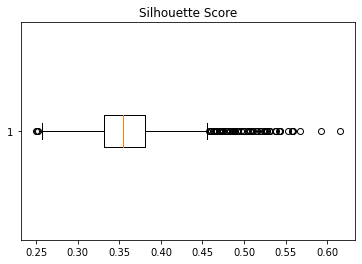

In [12]:
# plotting silhouette scores across interest and region combinations

fig1, ax1 = plt.subplots()
ax1.set_title('Silhouette Score')
ax1.boxplot(scores, vert=False)
plt.show()

_Figure 2: A distribution of all collected silhouette scores for the sample._

From the boxplot above we can see that the average silhouette score for the clusters were around 0.36, with the range from 0.25 to 0.6. As no results fell close to or below zero, this would suggests that the clusters are different from one another. However as it is very much below 1, our clusters are still not as clearly distinguished or significantly different from one another. 

#### Qualitative Evaluation

As a qualitative measure, we also compared our result to travel recommendations made by travel writers and websites. This was to compare our subjective recommendation with popular opinion and suggestions from travel professionals. 

We compared the countries listed on our recommender with other countries listed on blogs or recommendation websites with similar interests (e.g. travelling in Europe or best countries for museums). Through this we found that our recommendation were often similar to what others were suggesting. While there wasn't 100% similarity, there generally weren't any abnormal suggestions from our algorithm. 

Although it is worth noting that this evaluation method was purely a sense check. There were many limitations to this as it was difficult to find online recommendations which matched our specific user interests. Therefore it was simply used to double check if we had any outliers in certain suggestions.

#### Part B:
A clear description of the deployment process. An engaging and clear illustration of the product (games, shiny app, learning device etc) with a discussion of concepts from multiple disciplines.

### Deployment Process ####
Our deployment process consisted of several steps: planning, development, testing, and deployment of the final product. These steps are closely based on the PMKBOK Process Groups, widely used in project management domains [].

#### Planning ####
Our planning phase was multifaceted. 

First, we had to identify and acquire data from multiple sources. This included static sources such as reports, and dynamic constantly updating sources such as APIs and RSS feeds.

Then, we formulated the ensemble KNN and k-means size-constrained clustering algorithms. This was done through a combination of our own research and in consultation with the DATA3888 tutoring team. 

We then prototyped the dashboard design using wireframes and wireflows on paper and on the Figma [] web application. Prototyping in this way is a key process in the User Interface and User Experience disciplines. 

#### Development #### 
Our team then split into two discrete teams: an analytics team, and a UI group. We made use of GitHub in order to facillitate code sharing and collaboration. Both teams used a singular repository with multiple branches. 

The analytics code utilised the scikit-learn, numpy, pandas and k-means-constrained libraries, while the UI component was implemented using the Plotly Dash Python libraries [] and the Dash Extensions Python library []. The dashboard and code are served by a Python Flask [] server.

The analytics code and basic UI implementation were completed in parallel, with the teams working together in the last stage to implement application callbacks in order to utilise the analytics functionality within the dashboard.


#### Testing ####
Testing was performed during all stages of development in an ad-hoc manner (**did analytics do formal testing?**). Using a range of inputs into the dashboard, including normal input and edges cases, (nothing selected, everything selected, etc.) subsequent outputs were checked for consistent results and callback errors (provided via the Plotly Dash debug mode).

#### Deployment and Showcase of the Final Product #### 
After integration and final testing, the server was put into production mode. A feature of the application is that on initial startup, it fetches the most up-to-date information from our data sources.

A user will be first be greeted with a variety of options allowing them to select a destnation on interest, possible concerns, and travel interests. The subsequent results are based on the interests and concerns that the user selects. The travel recommendation system then provides ten to twelve destination recommendations, with their geographical locations highlighted on a map of the world.

*Figure X: User selected destination, concerns, and interests and resulting destination suggestions and portraits, with destinations highlighted on the world map.*

After this point, a user can click on a destination's portrait to view extra information about a destination, including travel warnings, a short description, covid statistics, and scores relating to the user's selected concerns and interests. 

*Figure X: Destination information for X, with travel warnings, a short description, and factor scores.*

## Discussion/Conclusion
Discussion of potential shortcomings or issues associated with the development process or the product with reference to both disciplines. Identification of future work or improvement in both disciplines. Conclusion adequately summarises the project and identification of future work.

## References

Bradley, P. S., Bennett, K. P., & Demiriz, A. (2000). Constrained k-means clustering. Microsoft Research, Redmond, 20(0), 0.

Destinations. Smartraveller. (2022). Retrieved 30 May 2022, from https://www.smartraveller.gov.au/destinations.

Google Places API. Google Developers. (2022). Retrieved 30 May 2022, from https://developers.google.com/maps/documentation/places/web-service.

Levy-Kramer, J. (2022). k-means-constrained.

Our World in Data, Coronavirus Disease (COVID-19) – the data [Dataset]. https://ourworldindata.org/coronavirus-data

triposo API. triposo. (2022). Retrieved 30 May 2022, from https://www.triposo.com/api/.

World Bank (2019). WEF Travel & Tourism Competitiveness [Dataset]. https://tcdata360-backend.worldbank.org/api/v1/datasets/78/dump.csv

## Appendix

## Student contributions

1. Eve Fernando
2. Marie Montgomery
3. Rayani Saha
4. Serena Watson
5. Stuart Toft
6. Yan Liu